# Binary Classification Model in PyTorch, with a +
Cleverson Matiolli, PhD

This is a notebook that I have made to learn how to implement a neural network in PyTorch. It is based on the post "Building a Binary Classification Model in PyTorch" by Adrian Tam (Machine Learning Mastery, https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch), but I've added detailed information about the dataset and lots of comments in the code. I also explore feature selection and visualization techniques to improve data interpretation and model accuracy. Thus, I have added some cool stuff that may be useful for you too. After selecting between a wide (but shallow) neural network and a deep neural network, I search for the best hyperparameters and regularization techniques to improve the model. I also compare the FNN model with more traditional statistical learning approaches such as Support Vector Machine for Classification (SVC) combined with grid search of hyperparameters for such models. Please take the information that I've added here with a grain of salt because it was not per-reviewed. 

**Steps**
1. Loading training data
2. Making data available to PyTorch
3. Designing Feedforward Neural Network (FNN) models
4. Defining the FNN training loop
5. Training and evaluating model's performance with k-fold cross-validation
6. Running the model in inference mode
7. Creating a receiver operating characteristics (ROC) curve for binary classification
8. Comparing neural networks and SVM classifier


## The Dataset

The data is the raw material of any data scientist (as the name might suggest...). Knowing it well is a big first step in developing a model that accuratelly predicts a label or a continuous value. Even if the learning algorithms crunch numbers no matter what they are, data scientists have to go deeper in understanding the story behind the data. Doesn't matter if you are a machine learning practitioner looking for a job or a small-medium company looking for new ways to increase profit, the data is the key.

The sonar dataset analyzed here can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)). Briefly, the sonar dataset  has 208 samples with 60 numerical variables representing the preprocessed and normalized return strengths of sonar signals bouncing on two different objects: a metal cylinder and a rock with a cylindrical shape, both with approximatelly 5 feet in length, put on sandy ocean floor.
The impinging pulses impinging pulses are a wide-band linear FM chirp rising in frequency (ka = 55.6) and returns were collected from different angles. The task is to discriminate Metal (M) from rock (R) using this features in a binary classification task. The dataset is slightly imbalanced, with 111 returns (samples) from a metal cylinder and 97 samples from a cylindrically shaped rock. The details on how the data was collected and processed and more information about the dataset can be found in the link's webpage and in the article below ([Gorman et al., 1988](https://doi.org/10.1016/0893-6080(88)90023-8)). The sonar dataset is a standard benchmarking dataset for machine learning with approximate accuracy of 85% using a feedforward neural network (FNN) for classification.


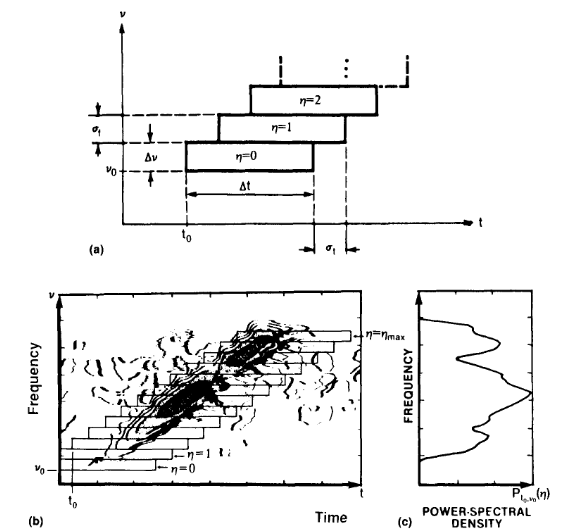

><font color="grey"> **Figure 1.** The preprocessing of the bouncing sonar signals produces a sampled spectral envelope normalized to vary from 0.0 to 1.0 for input to the network. (a) The set of sampling apertures offset temporally to correspond to the slope of the FM chirp, (b) sampling apertures superimposed over the 2D display of the short-term Fourier transform, (c) the spectral envelope obtained by integrating over each sampling aperture (Source: Figure 3, Gorman, R.Paul, and Terrence J. Sejnowski. “Analysis of Hidden Units in a Layered Network Trained to Classify Sonar Targets.” Neural Networks 1, no. 1 (January 1988): 75–89).</font> 




### Loading training data

First we load the raw data in a Pandas' DataFrame, which is a convenient format  for further exploratory data analysis (EDA) and data pre-processing:

In [29]:
import pandas as pd

# loading the dataset
df = pd.read_csv("./sonar.all-data.csv")
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


### Exploratory Data Analysis (EDA)

Building a accurate machine learning model heavily relies on quality of the data fed into it for training and testing. Analyzing how the data is distributed and how relevant they are for predicting the outcome is an essential part of designing an accurate model. An EDA is crucial because enables:

1. Feature selection: emcompasses a set of techniques to filter out those features that contain little information for the model. We seek for those features that has high variance but excluding the features that are highly correlated, thus redundant for training the model.
2. Feature engineering: understanding the data enables us to combine features to imporove model's performance.
3. Normalization and Standardization: most machine learning algorithms are sensitive to the scaling of the data, requiring normalization (scaling the data to a defined range) or standardization (shifting the distribution to mean = 0 and standard deviation = 1). Both approaches ensures that the model learning isn't dominated by features with high values compared to others (for example: the price and the total area of a house when prediction selling prices).
4. Outlier detection: Plotting the mean and variance of the dataset reveal outlier values, which could be detrimental for the model during the training process. In the end, machine learning algorithms are there to learn the distribution of the data in order to predict new values.

We do not expect that all features in a real-world dataset will be important for predicting the outcome, and we can use some dimensionality reduction and feature selection  A lighter dataset will result in a simpler and more powerfull model, with greater generalization capability when seeing new data.

To get some initial descriptive statistics of the dataset, the DataFrame method ``DataFrame.describe()`` shows the data central tendency, dispersion and quartile information.

In [30]:
display(df.describe())

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_51,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


We can notice that the standard deviations (*std*) are quite high, showing that the data is greatly dispersed around the mean. It is commonly believed that features with low variance contributes little to the model performance and with high variance contributes more. However this is far from truth because this notion disconsiders that features might come in different units (e.g. meters and millimeters) that might differ greatly in terms of mean and std values. However, these features can be important even in a narrow range when predicting the outcome of a model.

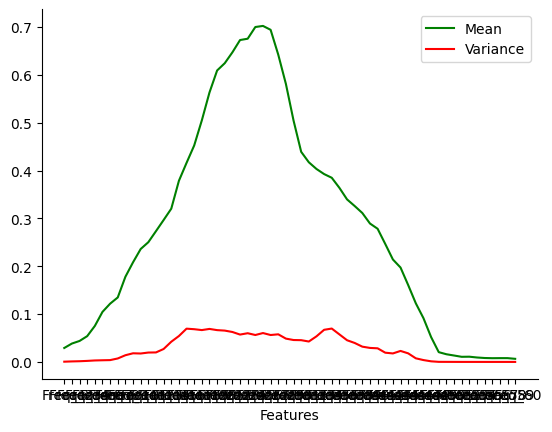

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_var = df.var(numeric_only=True, skipna=True)
feat_mean = df.mean(numeric_only=True, skipna=True)

disp = sns.lineplot(data=feat_mean, color="g", legend="brief", label="Mean")
disp = sns.lineplot(data=feat_var, color="r", legend="brief", label="Variance")
disp.set_xlabel("Features")
sns.despine()  # remove top and right spines

plt.show()

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# instantiate the scalers
sc_std = StandardScaler()
sc_mms = MinMaxScaler(feature_range=(0, 1))

# transformation (also a trick to preserve dataframe structure)
df_std = pd.concat(
    [
        pd.DataFrame(sc_std.fit_transform(df.iloc[:, :-1])),
        pd.Series(df.iloc[:, -1]),
    ],
    axis=1,
)

df_mms = pd.concat(
    [
        pd.DataFrame(sc_mms.fit_transform(df.iloc[:, :-1])),
        pd.Series(df.iloc[:, -1]),
    ],
    axis=1,
)

print("Standardization:\n")
display(df_std)

print("\nMin-Max:\n")
display(df_mms)

Standardization:



,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,Label
0,-0.399551,-0.040648,-0.026926,-0.715105,0.364456,-0.101253,0.521638,0.297843,1.125272,0.021186,...,-1.115432,-0.597604,0.680897,-0.295646,1.481635,1.763784,0.069870,0.171678,-0.658947,R
1,0.703538,0.421630,1.055618,0.323330,0.777676,2.607217,1.522625,2.510982,1.318325,0.588706,...,-0.522349,-0.256857,-0.843151,0.015503,1.901046,1.070732,-0.472406,-0.444554,-0.419852,R
2,-0.129229,0.601067,1.723404,1.172176,0.400545,2.093337,1.968770,2.852370,3.232767,3.066105,...,1.017585,0.836373,-0.197833,1.231812,2.827246,4.120162,1.309360,0.252761,0.257582,R
3,-0.835555,-0.648910,0.481740,-0.719414,-0.987079,-1.149364,-0.193816,-0.084747,-1.000852,-0.610469,...,-0.137365,-1.009341,0.557326,-0.111785,-0.161060,-0.488635,-0.549875,-0.639154,1.034640,R
4,2.050790,0.856537,0.111327,-0.312227,-0.292365,-0.672796,-0.013735,1.317299,1.510531,1.772220,...,-1.073812,-0.753780,-0.060532,0.241793,-1.174638,-0.107456,-0.487900,0.447361,0.576375,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,-0.456232,-0.116681,-0.705146,-0.779738,-0.647842,0.990954,1.314965,0.407323,0.463980,0.448504,...,-0.189390,-0.129077,1.230104,-0.847228,0.328253,-0.228741,0.550172,1.841992,1.831621,M
204,0.136733,-0.861801,-0.366036,0.054026,0.014392,-0.148740,-0.369029,-0.388465,-0.635067,0.053253,...,-0.761663,-0.200066,0.351373,-0.422934,-0.335815,-0.765856,-0.735798,-0.282388,0.038412,M
205,1.004381,0.160078,-0.673843,-0.531979,-0.723629,0.212502,0.064137,-0.200113,-0.442014,0.332912,...,0.268428,-1.108725,-0.801960,-0.437077,0.118548,1.070732,0.906526,-0.039138,-0.678871,M
206,0.049533,-0.095392,0.134804,0.148821,-1.055648,0.522865,0.401585,-0.264859,0.139685,0.202404,...,-0.501539,-0.867363,0.227802,-0.804798,-0.825128,-0.765856,-0.007598,-0.704020,-0.340154,M



Min-Max:



,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,Label
0,0.136431,0.156451,0.135677,0.035426,0.224956,0.237571,0.407468,0.340904,0.449282,0.285714,...,0.027104,0.155844,0.435673,0.149660,0.417949,0.502841,0.185355,0.245179,0.060046,R
1,0.323009,0.221603,0.272011,0.150024,0.283033,0.666756,0.574405,0.755458,0.483045,0.394537,...,0.108417,0.218182,0.111111,0.199546,0.479487,0.389205,0.105263,0.140496,0.087760,R
2,0.182153,0.246892,0.356110,0.243699,0.230028,0.585327,0.648810,0.819405,0.817859,0.869584,...,0.319544,0.418182,0.248538,0.394558,0.615385,0.889205,0.368421,0.258953,0.166282,R
3,0.062684,0.070724,0.199737,0.034950,0.034999,0.071486,0.288149,0.269239,0.077447,0.164593,...,0.161198,0.080519,0.409357,0.179138,0.176923,0.133523,0.093822,0.107438,0.256351,R
4,0.550885,0.282898,0.153088,0.079886,0.132640,0.147003,0.318182,0.531863,0.516659,0.621479,...,0.032810,0.127273,0.277778,0.235828,0.028205,0.196023,0.102975,0.292011,0.203233,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.126844,0.145735,0.050263,0.028293,0.082678,0.410642,0.539773,0.361411,0.333629,0.367653,...,0.154066,0.241558,0.552632,0.061224,0.248718,0.176136,0.256293,0.528926,0.348730,M
204,0.227139,0.040720,0.092970,0.120304,0.175755,0.230046,0.258929,0.212348,0.141419,0.291863,...,0.075606,0.228571,0.365497,0.129252,0.151282,0.088068,0.066362,0.168044,0.140878,M
205,0.373894,0.184741,0.054205,0.055635,0.072026,0.287288,0.331169,0.247630,0.175181,0.345488,...,0.216833,0.062338,0.119883,0.126984,0.217949,0.389205,0.308924,0.209366,0.057737,M
206,0.212389,0.148736,0.156045,0.130766,0.025361,0.336469,0.387446,0.235502,0.276914,0.320463,...,0.111270,0.106494,0.339181,0.068027,0.079487,0.088068,0.173913,0.096419,0.096998,M


Checking if it is a **balanced** dataset. Imbalanced datasets are bad for model training because the model becomes biased towards the majority label.

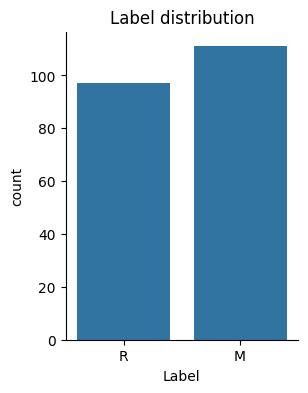

In [33]:
plt.figure(figsize=(3, 4))
sns.countplot(x="Label", data=df).set_title("Label distribution")
sns.despine()
plt.show()

The labels' distribution is almost balanced. We can also take a look at some density estimates of three variables. Instead of using an histogram to approximate the probability density function, we will use kernel density estimation (KDE) that "smooths" the histogram and present a continuous density estimate.

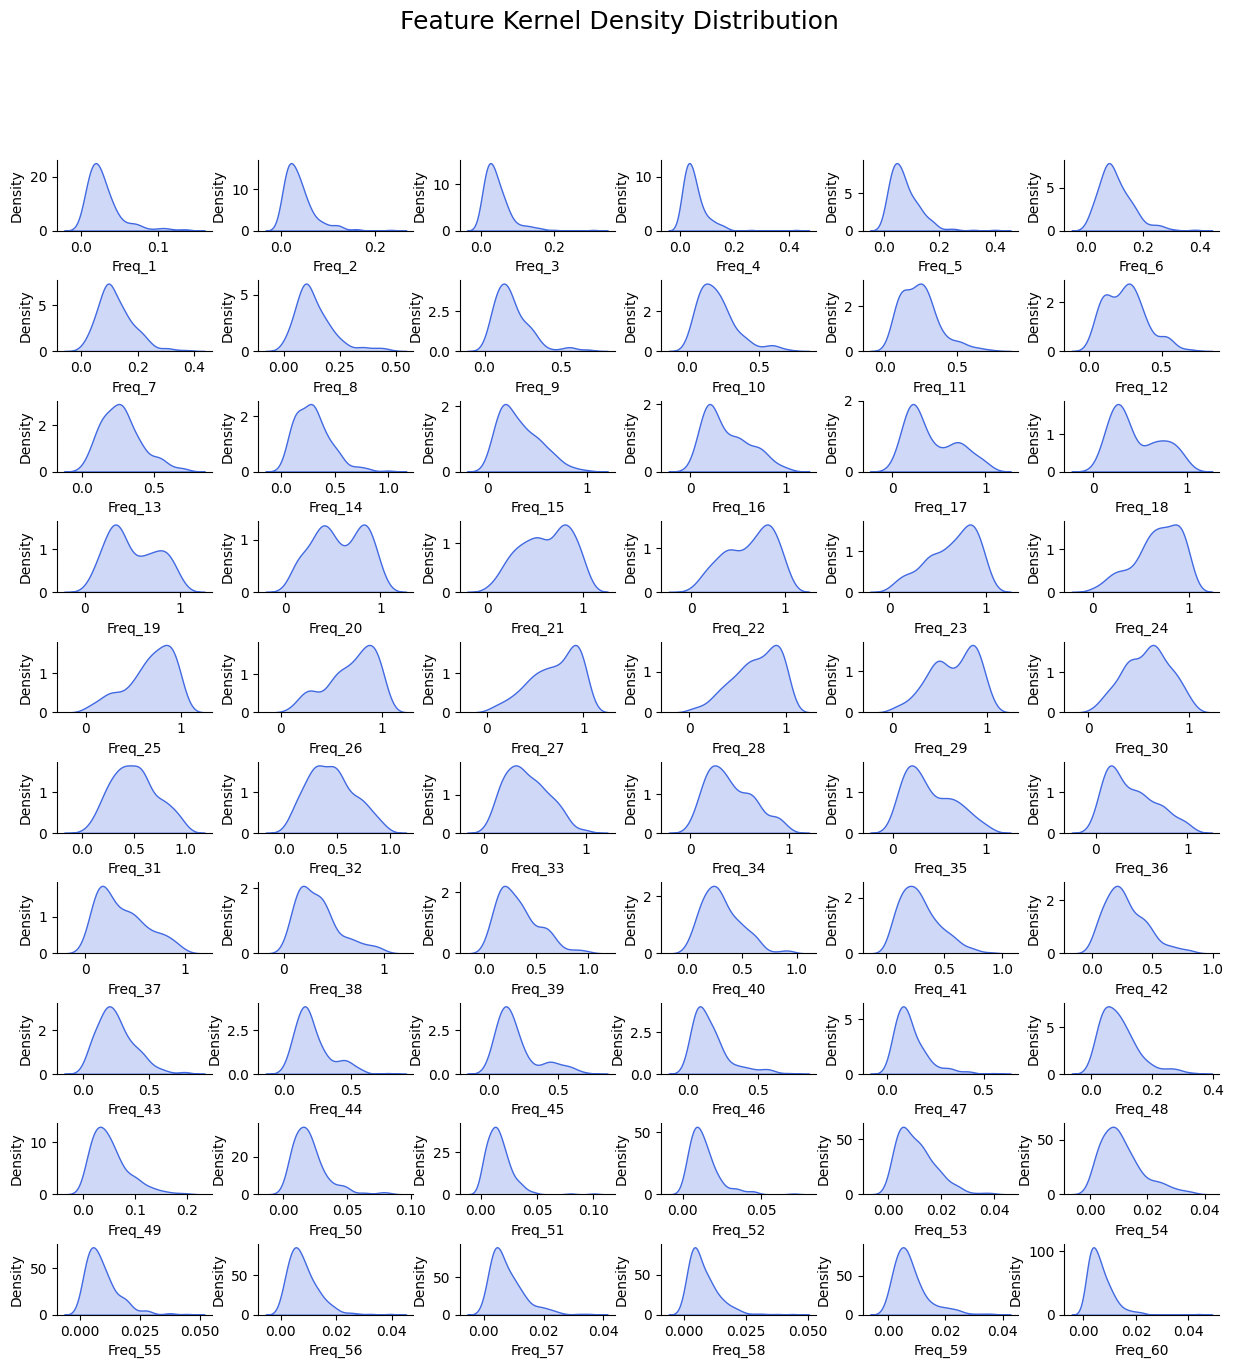

In [34]:
# creating subplots
fig, axs = plt.subplots(10, 6, figsize=(15, 15))
plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.suptitle("Feature Kernel Density Distribution", fontsize=18)
sns.despine()

# iterating through dataset to plot in axes
for feat, ax in zip(df.columns, axs.ravel()):
    sns.kdeplot(data=df[feat], fill=True, ax=ax, color="royalblue")
plt.show()

Let's see how the scaled data looks like in the KDE plots:

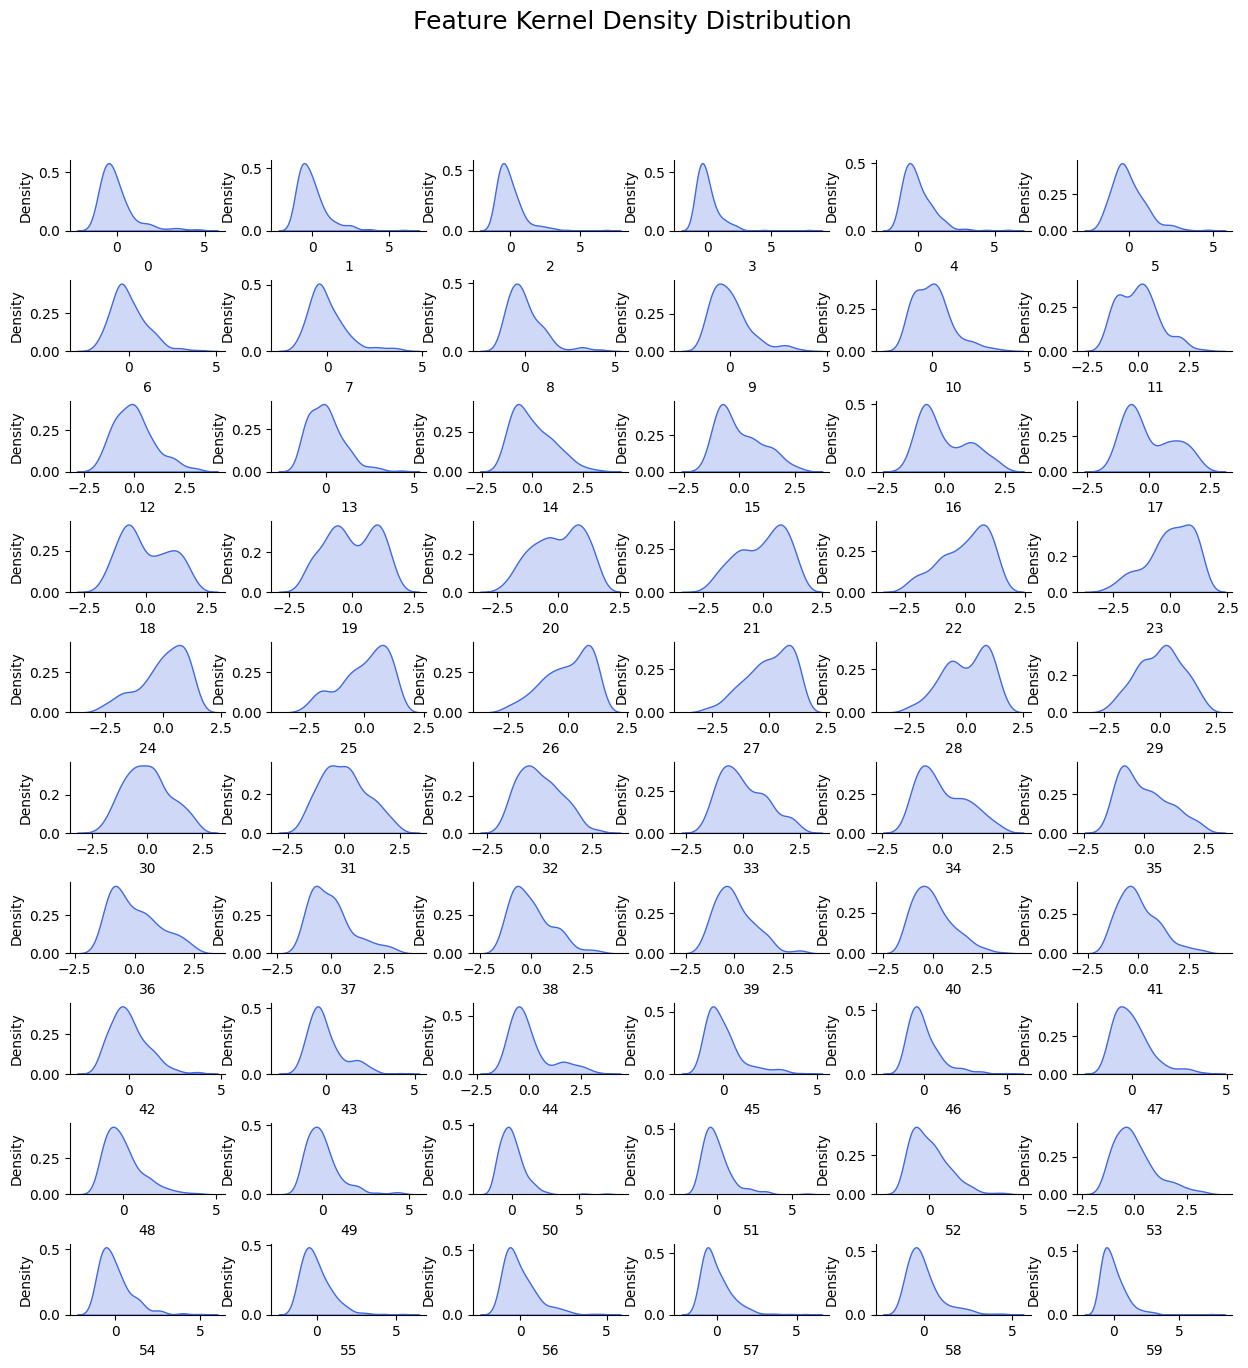

In [35]:
# creating subplots
fig, axs = plt.subplots(10, 6, figsize=(15, 15))
plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.suptitle("Feature Kernel Density Distribution", fontsize=18)
sns.despine()

# iterating through dataset to plot in axes
for feat, ax in zip(df_std.columns, axs.ravel()):
    sns.kdeplot(data=df_std[feat], fill=True, ax=ax, color="royalblue")
plt.show()

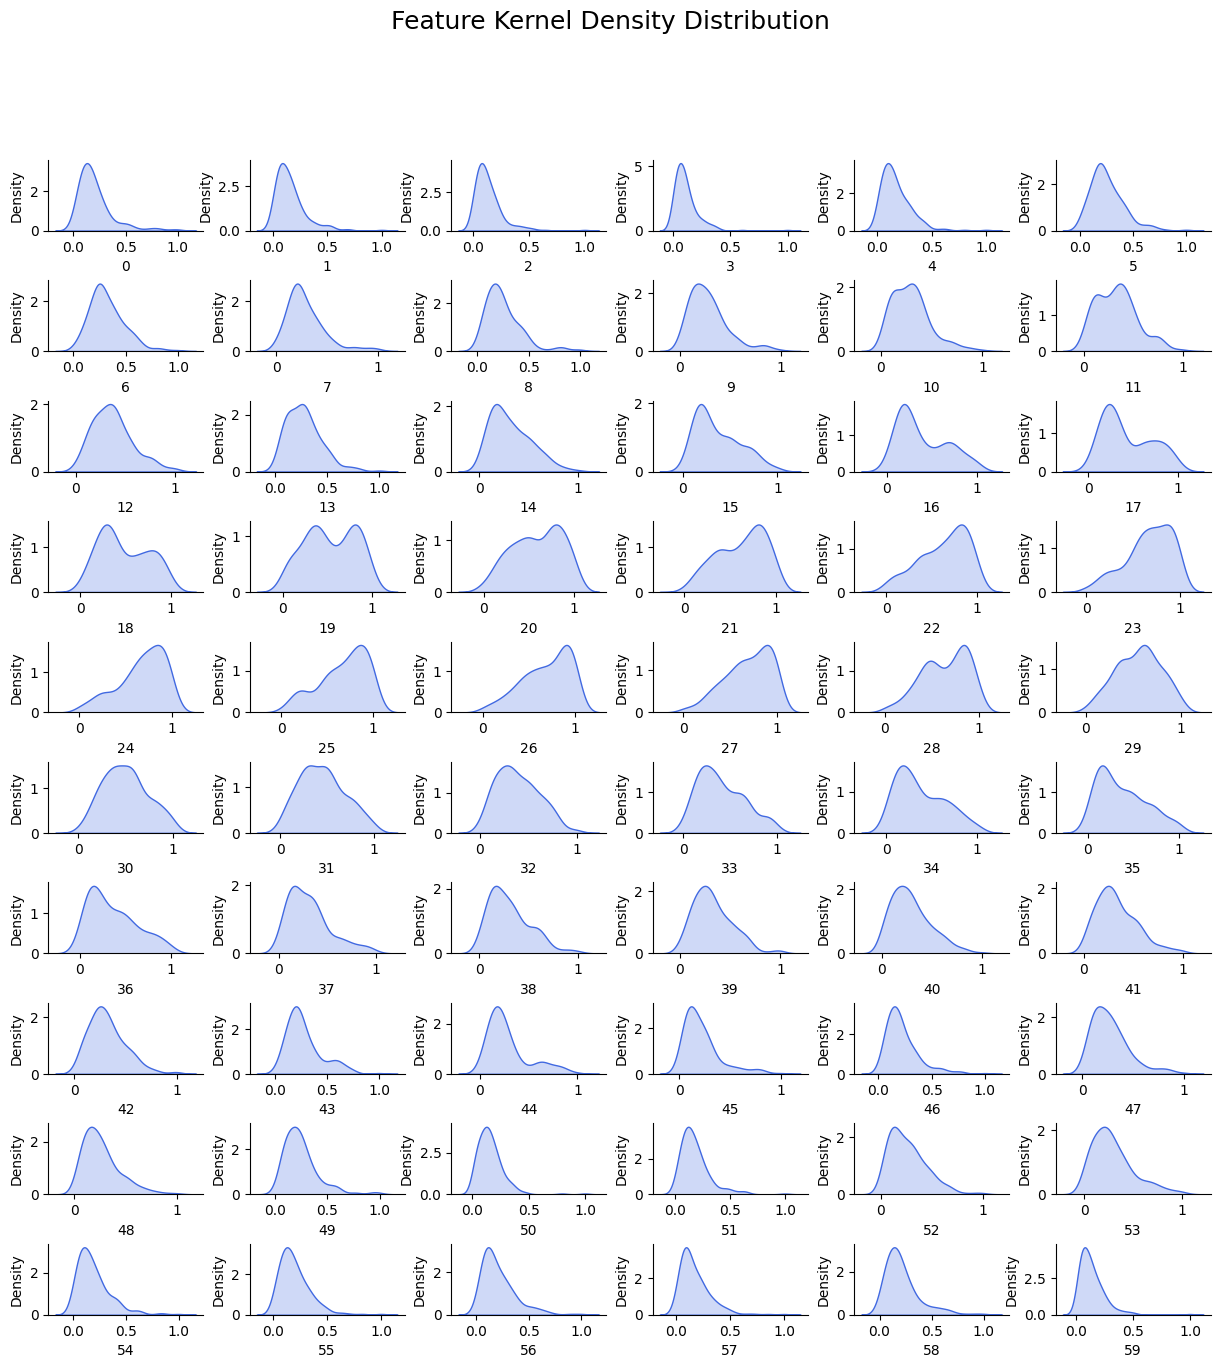

In [36]:
# creating subplots
fig, axs = plt.subplots(10, 6, figsize=(15, 15))
plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.suptitle("Feature Kernel Density Distribution", fontsize=18)
sns.despine()

# iterating through dataset to plot in axes
for feat, ax in zip(df_mms.columns, axs.ravel()):
    sns.kdeplot(data=df_mms[feat], fill=True, ax=ax, color="royalblue")
plt.show()

Checking the relationship between some randomly choosen features.

Pearson's correlation coefficient: R=0.736, P=0.000


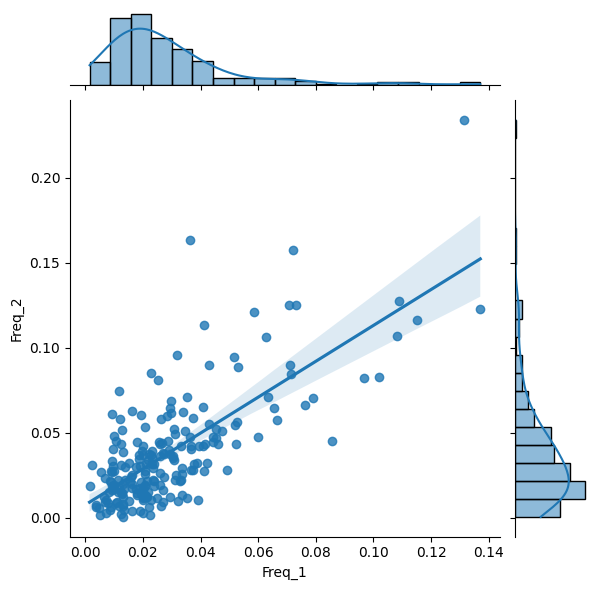

In [37]:
from scipy import stats

# Pearson's correlation coefficient
r, p = stats.pearsonr(x=df["Freq_1"], y=df["Freq_2"])
print("Pearson's correlation coefficient: R={:.3f}, P={:.3f}".format(r, p))

disp = sns.jointplot(data=df, x="Freq_1", y="Freq_2", kind="reg")
plt.show()

Pearson's correlation coefficient: R=-0.428, P=0.000


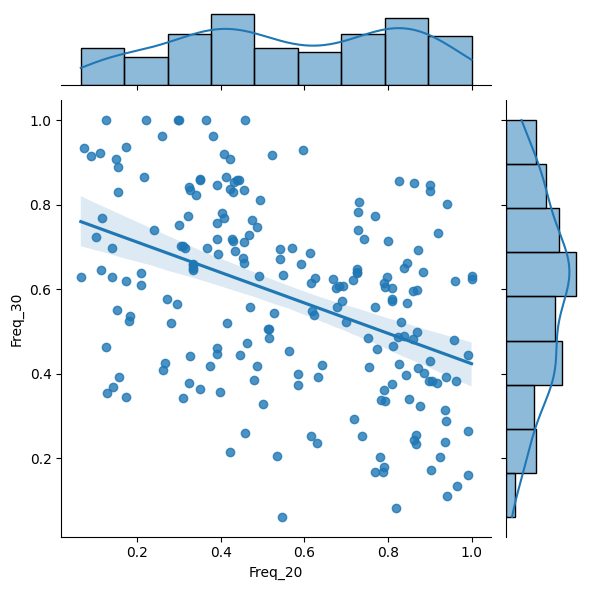

In [38]:
# Pearson's correlation coefficient
r, p = stats.pearsonr(x=df["Freq_20"], y=df["Freq_30"])
print("Pearson's correlation coefficient: R={:.3f}, P={:.3f}".format(r, p))

disp = sns.jointplot(data=df, x="Freq_20", y="Freq_30", kind="reg")
plt.show()

It seems that we have some highly correlated features. Some of these features could be excluded from training to get a simpler and lighter classification model. Eliminating highly correlated features can make our dataset less "noisy" and our model simpler. A correlation heatmap plot can show correlated variables and the correlation degree, direction (positive or negative correlation).

>To plot the ``heatmap`` we might use a divergent color map to clearly show the positive and negative correlations.

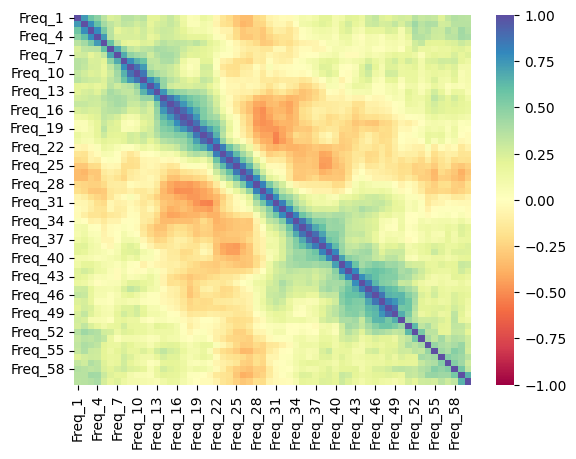

In [39]:
df_corr = df.corr(numeric_only=True)  # numeric_only excludes the target label column
heatplot = sns.heatmap(data=df_corr, vmin=-1, vmax=1, cmap="Spectral")
plt.show()

There're both positive and negative correlations between variables, as we can see in the heatmap. I guess it looks like an green alien :-|. We can get a *mask* of absolute correlations to pick variables. When training the model, it can be useful to set different correlation thresholds and see how model's accuracy behaves. For now lets set the threshold to 1 to get the full dataset for training and testing.

In [40]:
import numpy as np

# get the mask (upper half of correlation matrix, absolute)
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
display(upper.head())

# filter correlation by threshold
threshold = 0.8
cols_to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
print(
    f"There are {len(cols_to_drop)} features with correlation higher than {threshold}."
)

# drop correlated columns
df.drop(columns=cols_to_drop, axis=1, inplace=True)
df.head()

# store the number of remaining features (will be used to define the input size during training)
num_features = len(df.columns) - 1  # features minus label columns
print(f"There are {num_features} remaining in the dataset.")

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_51,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60
Freq_1,NaN,0.735896,0.571537,0.491438,0.344797,0.238921,0.260815,0.355523,0.353420,0.318276,...,0.254450,0.355299,0.311729,0.322299,0.312067,0.220642,0.313725,0.368132,0.357116,0.347078
Freq_2,NaN,NaN,0.779916,0.606684,0.419669,0.332329,0.279040,0.334615,0.316733,0.270782,...,0.320538,0.434548,0.346076,0.383960,0.380165,0.262263,0.280341,0.353042,0.352200,0.358761
Freq_3,NaN,NaN,NaN,0.781786,0.546141,0.346275,0.190434,0.237884,0.252691,0.219637,...,0.238110,0.394076,0.332914,0.367186,0.289731,0.287661,0.380819,0.334108,0.425047,0.373948
Freq_4,NaN,NaN,NaN,NaN,0.726943,0.352805,0.246440,0.246742,0.247078,0.237769,...,0.174676,0.374651,0.364772,0.334211,0.284955,0.280938,0.340254,0.344865,0.420266,0.400626
Freq_5,NaN,NaN,NaN,NaN,NaN,0.597053,0.335422,0.204006,0.177906,0.183219,...,0.115936,0.266617,0.314985,0.205306,0.196472,0.199323,0.219395,0.238793,0.290982,0.253710


There are 32 features with correlation higher than 0.8.
There are 28 remaining in the dataset.


How the data look like after dropping highly correlated columns:

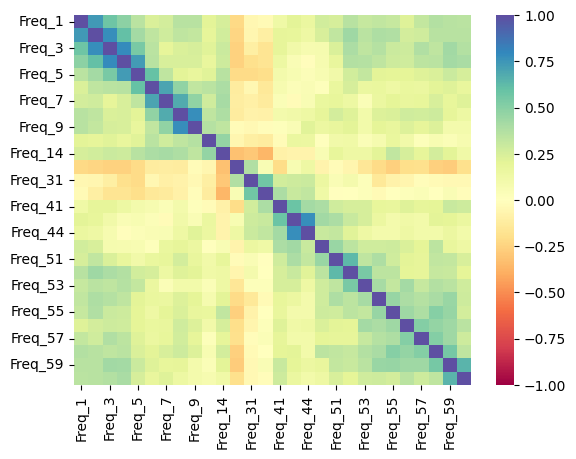

In [41]:
sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, cmap="Spectral")
plt.show()


### Making data available to PyTorch

First, lets split the training data into a *feature matrix* and a target *label vector*. Here we convert the labels into numbers using ``LabelEncoder``.

In [42]:
from sklearn.preprocessing import LabelEncoder

# split into features' vector and labels vector
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encoding labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

print(f"Labels: {encoder.classes_} = [Metal, Rock] encoded into:")
print(y)


Labels: ['M' 'R'] = [Metal, Rock] encoded into:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [43]:
# converting features and labels to tensors
import torch

x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

print(f"features dim: {x.shape}")
print(f"labels dim: {y.shape}")


features dim: torch.Size([208, 28])
labels dim: torch.Size([208, 1])


##  Designing Feedforward Neural Network (FNN) models

The model is built using the PyTorch *nn* module, which is the base class for neural networks built in PyTorch and allows nested
tree structure where submodules can be assigned as regular attributes. Just a refresher:


>>A FNN in PyTorch has fully-connected layers as **attributes** and a forward **method** defining the network architecture and how the data will do the forward pass through the network.

>**attributes**: variables stored in an instance or class

>**methods**: functions encoded in an instance or class 

In a neural network the number of layers and the number of neurons in each layer are hyperparameters, i.e., parameters hard-coded before training. A deep learning model has *more than one* hidden layer, while models with more parameters in the layers is a wider model. Here we test both to determine which one will give more accurate predictions.



In [44]:
# defining the wide neural network structure (a single hidden layer)

import torch.nn as nn


# The neural network child class is derived from nn.Module base class
# In the constructor, declare all the layers of the network
class Wide(nn.Module):
    # instantiate all modules (their attributes and methods)
    def __init__(self):
        # initialize attributes and methods of the parent class
        super().__init__()
        # input layer for 60 variables (60 units or neurons) and 180 output units
        self.hidden = nn.Linear(in_features=num_features, out_features=180)
        # activation of the layer (breaking linearity)
        self.relu = nn.ReLU()
        # the output is a real number for binary classification...
        self.output = nn.Linear(in_features=180, out_features=1)
        # ...and the sigmoid takes the input (1) tensor and squeeze (reescale) it to [0,1] range
        # representing the probability of the target label of a given sample.
        # class 1 = P, class 2 = 1 - P(class 1)
        # Note: sigmoid is used for binary classification, softmax is an extension of sigmoid for multiclass problems
        self.sigmoid = nn.Sigmoid()

    # the forward function defines the neural network structure, with
    # number of units (neurons), activations, regularizations, outputs...
    # Then, here we define how the network will be run from input to output:
    def forward(self, x):
        # taking the input, computing weigths and applying non-linearity
        x = self.relu(self.hidden(x))
        # taking the output of the previous layer and squeezing it
        # to the range [0,1]
        x = self.sigmoid(self.output(x))
        return x  # x is the probability of class 1, while class 2 is (1-x)


wide_model = Wide()
wide_model

Wide(
  (hidden): Linear(in_features=28, out_features=180, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=180, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [45]:
# defining the deep neural network structure (more than one hidden layer)


class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=num_features, out_features=60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x


# instantiate the models and move them to the GPU
deep_model = Deep()
deep_model

Deep(
  (layer1): Linear(in_features=28, out_features=60, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=60, out_features=60, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=60, out_features=60, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [46]:
# testing the data flow through the the networks with random data
# the result will be around 0.5 probability because the network
# isn't trained yet and data is just blah blah blah for the model.
random_data = torch.rand(num_features)
print(random_data)

result_wide = wide_model(random_data)
result_deep = deep_model(random_data)

print(f"\nResult Wide: {result_wide}")
print(f"Result Deep: {result_deep}")


tensor([0.6246, 0.8712, 0.1875, 0.0330, 0.9478, 0.1582, 0.1957, 0.8506, 0.4401,
        0.9113, 0.4836, 0.3173, 0.6702, 0.0449, 0.5033, 0.6126, 0.6826, 0.4080,
        0.3710, 0.9690, 0.0521, 0.9154, 0.0044, 0.2173, 0.6807, 0.8593, 0.0599,
        0.5715])

Result Wide: tensor([0.4980], grad_fn=<SigmoidBackward0>)
Result Deep: tensor([0.4772], grad_fn=<SigmoidBackward0>)


### Defining the FNN training loop

After defining the network attributes and the forward method we can create the training loop, which will feed batches of data to the model, get the output  to calculate the loss and using this loss in the backward pass to update the learnable parameters (i.e. weights and biases) of the network in each iteration (batch).

 >The loss function calculates the difference between the predicted output and the ground truth labels. The optimizer adjust the parameters of the network towards minimization of the difference between the predictions and the actual labels.

 We define both the loss function and optimizers in the training loop to instantiate them in each iteration, allowing unbiased comparison between the performance of the models.

In [47]:
from tqdm.notebook import tqdm_notebook
import copy

# tqdm makes it easy to implement a progress bar
# to monitor the training status and time
tqdm_notebook.pandas()


def model_train(model, x_train, y_train, x_test, y_test, n_epochs=250, batch_size=10):
    # two labels, binary cross-entropy loss
    criterion = nn.BCELoss()
    # Adam is a stochastic gradient descent optimizer
    # that requires little memory and parameter tuning
    optim = torch.optim.Adam(model.parameters(), lr=0.0001)

    batch_start = torch.arange(start=0, end=len(x_train), step=batch_size)

    # keeps the best model
    best_acc = -np.inf  # starting at negative infinity
    best_weights = None  # hold the best learnt parameters

    # training loop (epoch counter)
    for epoch in range(n_epochs):
        model.train()  # set the model to training mode (e.g. activates dropout layers)
        with tqdm_notebook(
            batch_start, unit="batch", mininterval=0, disable=True
        ) as bar:
            bar.set_description(f"Epoch: {epoch}")
            for start in bar:
                # get the batch
                x_batch = x_train[start : start + batch_size]
                y_batch = y_train[start : start + batch_size]
                # FNN forward pass: obtain predictions and loss of each training batch
                y_pred = model(x_batch)  # predicts labels for training batch
                loss = criterion(y_pred, y_batch)  # calculate the loss of the batch
                # FNN backward pass:
                optim.zero_grad()  # zero the parameter gradients of previous runs
                loss.backward()  # accumulates dloss/dx for every parameter that requires_grad=True
                # update weigths using the accumulated loss stored in parameter_x.grad
                optim.step()
                # print training progress (accuracy and loss).
                # using accuracy but for highly imbalanced datasets use balanced accuracy
                # compute metrics after the optimization step to obtain metrics for the batch
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(loss=float(loss), acc=float(acc))

        # calculates the accuracy after each epoch, i.e. when
        # all the training data have passed through the network.
        # model.eval(): turns off parts of the model (e.g. dropout layers)
        # used for training that aren't used in inference mode
        # torch.no_grad(): disable autograd and may speed up computation
        model.eval()
        with torch.no_grad():
            y_pred = model(x_test)
            acc = float((y_pred.round() == y_test).float().mean())
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
    # returns the best model (based on the best accuracy)
    model.load_state_dict(best_weights)
    return best_acc

### k-fold Cross-Validation

With the data preprocessed and the network architectures on hands, we can carry out a competition between these two approaches to determine the best estimator.

>**Note:** We cannot test the model with the same data we've used for training the model because the model will simply repeat the labels of samples already seen. We have to separate a fraction of the full dataset to present it to the model and see if the model can generalize well for samples never seen before. 

Here we will seek the how accurate are the predictions of a test set after a number of iterations between these two models. The metrics will be recorded for later evaluation, but the best model can be used right the way because we will encode its instatiation and training.

>The competition between the two networks is mediated by [k-fold cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) from [scikit-learn](https://scikit-learn.org/stable). The k-fold cross-validation allows dinamic k-fold splits of the data into training and test sets. It is similar to the *Leave One Out* strategy. Doing this we avoid choosing a model due to a good result just by chance arising from splitting the training data. Here, we assume that the data is Independent and Identically Distributed (i.i.d.), meaning that they where obtained using the same process and each sample doesn't have a "memory" of past samples.

The k-fold cross-validation is good to choose parameters for the model. In this case, the network architecture is the parameter we're testing.

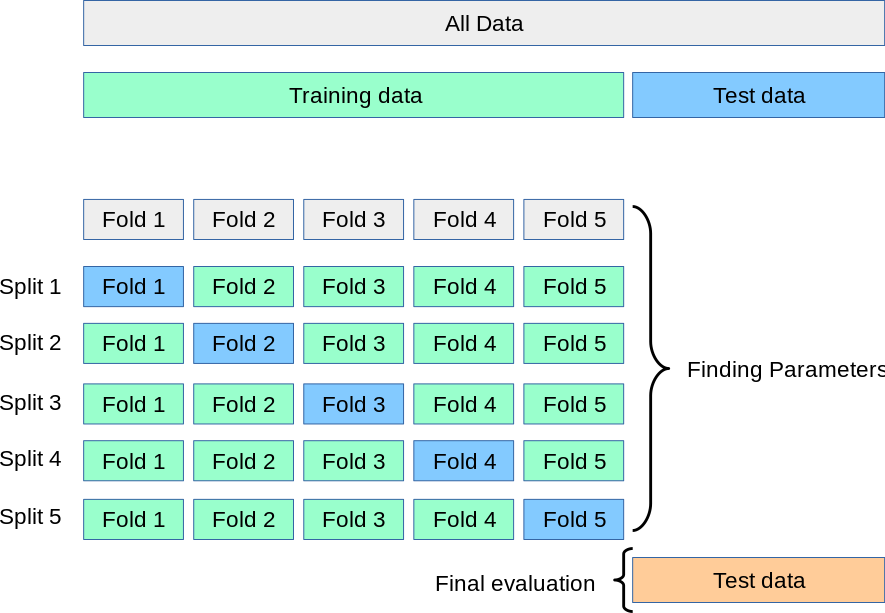

><font color="blue">**Figure 2.** In k-fold cross-validation we randomly split all data into training and test sets *k* times. In each fold, a different chunck of  data is held aside for validation after training with the remaing data. (Source: [Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold)).</font> 

For this task we can use StratifiedKFold from Sklearn, which returns samples's indices to split the data while preserving the percentage of samples of each label among the splits. We can set the number of splits and a integer seed to control randomness and ensure reproducibility during model evaluation. First, lets see the StratifiedKFold behavior when generating indices:

In [48]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(kfold.split(x, y)):
    print(f"Fold {i}:")
    print(f"    Train:  index={train_idx[:10]}")
    print(f"    Test:   index={test_idx[:10]}")

Fold 0:
    Train:  index=[ 0  1  2  4  5  6  7 10 11 12]
    Test:   index=[ 3  8  9 15 17 23 26 28 34 38]
Fold 1:
    Train:  index=[0 1 2 3 4 5 6 7 8 9]
    Test:   index=[10 13 16 24 25 31 32 37 40 43]
Fold 2:
    Train:  index=[ 0  2  3  4  5  6  8  9 10 11]
    Test:   index=[ 1  7 12 14 20 35 42 47 59 61]
Fold 3:
    Train:  index=[ 1  2  3  4  5  7  8  9 10 12]
    Test:   index=[ 0  6 11 19 21 22 29 36 39 54]
Fold 4:
    Train:  index=[ 0  1  3  6  7  8  9 10 11 12]
    Test:   index=[ 2  4  5 18 27 30 33 45 56 58]


In [49]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, shuffle=True, random_state=123)

# setting kfold parameters
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# lists to hold the cross-validation scores
n_epochs = 250
cv_scores_wide = []
cv_scores_deep = []

# kfold-split loops for each model
fold_counter = 0
for train_index, test_index in kfold.split(x_train, y_train):
    model = Wide()
    acc = model_train(
        model,
        x_train[train_index],
        y_train[train_index],
        x_train[test_index],
        y_train[test_index],
        n_epochs=n_epochs,
    )
    fold_counter += 1
    print(f"Fold {fold_counter}")
    print("Accuracy Wide Model: {:.2%}".format(acc))
    cv_scores_wide.append(acc)

fold_counter = 0
for train_index, test_index in kfold.split(x_train, y_train):
    model = Deep()
    acc = model_train(
        model,
        x_train[train_index],
        y_train[train_index],
        x_train[test_index],
        y_train[test_index],
        n_epochs=n_epochs,
    )
    fold_counter += 1
    print(f"Fold {fold_counter}")
    print("Accuracy Deep Model: {:.2%}".format(acc))
    cv_scores_deep.append(acc)

# printing scores of both nets
acc_wide, std_wide = np.mean(cv_scores_wide), np.std(cv_scores_wide)
acc_deep, std_deep = np.mean(cv_scores_deep), np.std(cv_scores_deep)
print("\nAccuracy Wide Model: {:.2%} (+/- {:.2%})".format(acc_wide, std_wide))
print("Accuracy Deep Model: {:.2%} (+/- {:.2%})".format(acc_deep, std_deep))

Fold 1
Accuracy Wide Model: 68.97%
Fold 2
Accuracy Wide Model: 75.86%
Fold 3
Accuracy Wide Model: 86.21%
Fold 4
Accuracy Wide Model: 79.31%
Fold 5
Accuracy Wide Model: 72.41%
Fold 1
Accuracy Deep Model: 72.41%
Fold 2
Accuracy Deep Model: 82.76%
Fold 3
Accuracy Deep Model: 86.21%
Fold 4
Accuracy Deep Model: 79.31%
Fold 5
Accuracy Deep Model: 79.31%

Accuracy Wide Model: 76.55% (+/- 5.93%)
Accuracy Deep Model: 80.00% (+/- 4.57%)


As we can see, the Deep() model performs better. Indeed, it has been demonstrated that deeper neural networks, i.e. with more than one hidden layer, are able to capture more complexity from the data than shallow networks. However, deep networks are more computionally expensive for training and can be challenging to optimize the number of layers and neurons, additional dropout layers (see below), etc. On the other hand, shallow networks are relatively inexpensive computionally and can be tweaked more easily. Also, deeper networks may require more data for training to avoid overfitting.

>**Overfitting:** A model is overfit when it learned most of the noisy in the data. In other words, the model "memorizes" the training data and has little generalization capabilities when tested with data previouslly unseen by the model.

>**Underfitting:** A model is underfit when it has poor prediction power on both training and testing data. In other words, the model still requires training to adjust the weights and biases of the network.

Now that we have a decision on the best model, we can retrain the network using all the training data.

In [50]:
model = Deep()
acc = model_train(model, x_train, y_train, x_test, y_test)
print("Accuracy Deep Model: {:.2%}".format(acc))


Accuracy Deep Model: 74.60%


And perform some model evaluations in inference mode... Lets get 5 samples at random and check if the model correctly predict the labels. In production, the model is usually deployed on a few samples.

In [51]:
import random

model.eval()
with torch.no_grad():
    for idx in range(5):
        # generates a random index in x_test index range
        rnd_int = sum(random.sample(range(0, len(x_test)), k=1))
        prediction = model(x_test[rnd_int]).detach().numpy()
        print(
            "Sample {} label: {} \nPredicted label: {}. (output: {}).\n".format(
                rnd_int, y_test[rnd_int].round(), prediction.round(), prediction
            )
        )

Sample 13 label: tensor([0.]) 
Predicted label: [0.]. (output: [0.44842848]).

Sample 42 label: tensor([0.]) 
Predicted label: [0.]. (output: [0.39609286]).

Sample 52 label: tensor([0.]) 
Predicted label: [0.]. (output: [0.44395652]).

Sample 28 label: tensor([0.]) 
Predicted label: [0.]. (output: [0.44825667]).

Sample 14 label: tensor([0.]) 
Predicted label: [1.]. (output: [0.51405966]).



Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.89      0.80        36
         1.0       0.79      0.56      0.65        27

    accuracy                           0.75        63
   macro avg       0.76      0.72      0.73        63
weighted avg       0.75      0.75      0.74        63



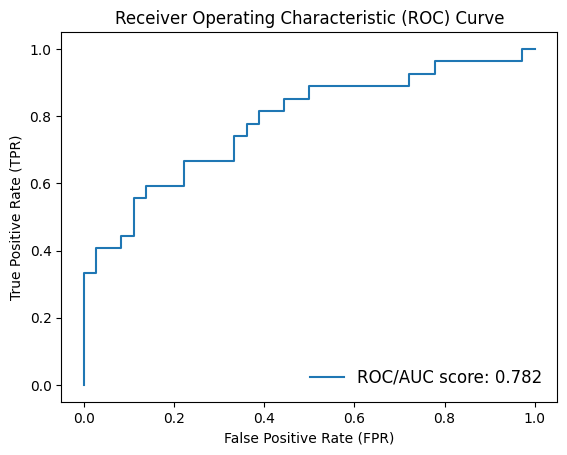

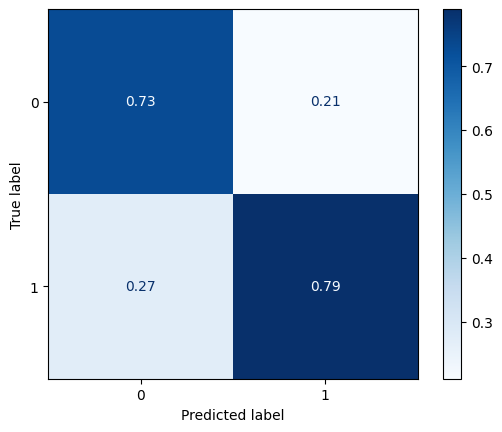

In [52]:
from sklearn.metrics import (roc_curve,
                             roc_auc_score,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             classification_report
                            )
                            

# predict testing set labels
y_pred = model(x_test)

# remove computational graph from tensor and convert to numpy array
y_pred = y_pred.ravel().detach().numpy()

# print classification report
print(f"Classification Report:\n{classification_report(y_test, y_pred.round())}")

# get ROC and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred)
score = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.ylabel("True Positive Rate (TPR)")
plt.xlabel("False Positive Rate (FPR)")

# add custom legend with AUC score
score = "ROC/AUC score: " + str(score.round(decimals=3))
plt.legend(labels=[score], loc="lower right", edgecolor="w", fontsize=12)
plt.show()

# confusion matrix
cm = confusion_matrix(y_test.ravel().detach().numpy(), y_pred.round(), normalize="pred")
cm = ConfusionMatrixDisplay(cm).plot(cmap="Blues")


In the *classification report*, the metrics are:
- **Precision**: True Positives divided by the total of positive samples predicted by the model. Measures how the model get the right label among the ones predicted as positive.

- **Recall** (also called *sensitivity* or *true positive rate (tpr)*): True Positives divided by all positive samples in the input (i.e. ground-truth positives). Measures how

## Logistic Regression
What about the classic statistical learning models? They do a pretty good job in most commonly found problem scenarios in the market. Let's see if Logistic Regression or Support Vector Machine (SVM) classifiers  beat the deep learning model.

Let's try these out-of-the-box models and then search for the best hyperparameters using GridSearchCV or RandomizedSearchCV from Sklearn. Before that, we convert PyTorch tensors, that has additional characteristics (e.g. computational graph to compute gradients in the FNN) to NumPy arrays for Sklearn algorithms. 

In [53]:
# detach computational graph and convert to ndarray
x_train, y_train = x_train.detach().numpy(), y_train.ravel().detach().numpy()
x_test, y_test = x_test.detach().numpy(), y_test.ravel().detach().numpy()

print(f"Types x {type(x_train)} and y {type(y_train)}.")
print(f"Types x {type(x_test)} and y {type(y_test)}.")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


Types x <class 'numpy.ndarray'> and y <class 'numpy.ndarray'>.
Types x <class 'numpy.ndarray'> and y <class 'numpy.ndarray'>.
x_train shape: (145, 28)
y_train shape: (145,)
x_test shape: (63, 28)
y_test shape: (63,)


Maybe the out-of-the-box classifiers can do a good job, starting by modeling the outcome probabilities with the logistic function using Logistic Regression (a.k.a. logit model) from Sklearn. Because the outputs are probabilities of a trial outcome, it works as a classifier based on threshold (by default the threshold is 0.5). It has interesting regularization options:

>**C:** Controls the strength of the regularization (determined by *1/C*) to be applied on the coeficients (there is one coefficient *w* for each feature and a constant bias *b*) during training. High C values (like C=100) determine low regularization strength and we expect that the training data is representative of real-world data because extreme values, if any, can lead to overfitting. On the other hand, low C values (0.1, 0.001) says to the model to take more care of the coefficients when training and regularization is then applied at the expense of fitting the model (in other words, reducing overfitting). Basically it says to the model how the training data is representative of real-world data.

>**Penalty (None, L1 (LASSO), L2 (Ridge) and elasticnet):** regularization terms applied to the cost function to control overfitting by tackling extreme coefficient values of the objective function. *L1* regularization is also called *lasso regression* and adds the coefficient's absolute magnitude to the loss function, while *L2* adds the squared magnitude. *Elasticnet* applies both L1 and L2 regularization where the ammount of each one is determined by the l1_ratio parameter, which is equivalent to L1 when its value is 1 and L2 when the ratio is 0.


Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76        36
         1.0       0.68      0.63      0.65        27

    accuracy                           0.71        63
   macro avg       0.71      0.70      0.71        63
weighted avg       0.71      0.71      0.71        63



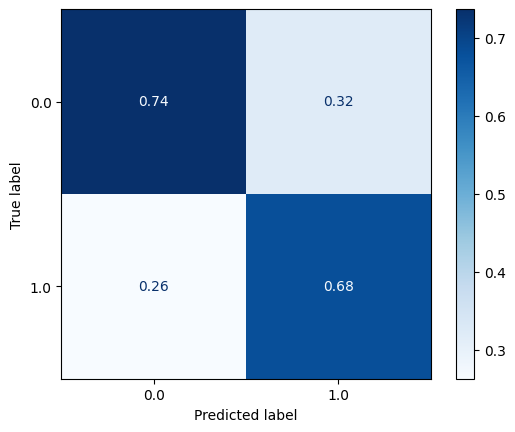

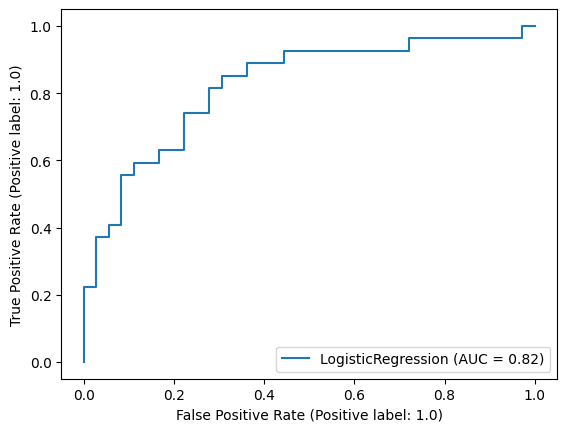

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

clf = LogisticRegression(random_state=42)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
cm = ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test, cmap="Blues", normalize="pred")
disp = RocCurveDisplay.from_estimator(clf, x_test, y_test)


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# just ignoring sklearn warnings for this code
import warnings
warnings.filterwarnings("ignore")

# instantiate the classifier
clf = LogisticRegression(random_state=42, verbose=0)

# define parameters' options dictionary for tunning
params = {
    "penalty": [None, "l2", "l1", "elasticnet"],
    "C": np.logspace(-3, 3, 8),
    "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
    # "max_iter": [100, 250, 500],
    "warm_start": [True, False],
    "l1_ratio": np.logspace(-1, 0, 8)
}

grid = GridSearchCV(estimator=clf, param_grid=params, cv=5)
grid.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.00000000e-03, 7.19685673e-03, 5.17947468e-02, 3.72759372e-01,
       2.68269580e+00, 1.93069773e+01, 1.38949549e+02, 1.00000000e+03]),
                         'l1_ratio': array([0.1       , 0.13894955, 0.19306977, 0.26826958, 0.37275937,
       0.51794747, 0.71968567, 1.        ]),
                         'penalty': [None, 'l2', 'l1', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga'],
                         'warm_start': [True, False]})

GridSearchCV best parameters: {'C': 138.94954943731358, 'l1_ratio': 0.09999999999999999, 'penalty': 'l1', 'solver': 'liblinear', 'warm_start': True}
GridSearchCV best score: 0.7379310344827587
GridSearchCV best estimator: LogisticRegression(C=138.94954943731358, l1_ratio=0.09999999999999999,
                   penalty='l1', random_state=42, solver='liblinear',
                   warm_start=True)
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76        36
         1.0       0.68      0.63      0.65        27

    accuracy                           0.71        63
   macro avg       0.71      0.70      0.71        63
weighted avg       0.71      0.71      0.71        63



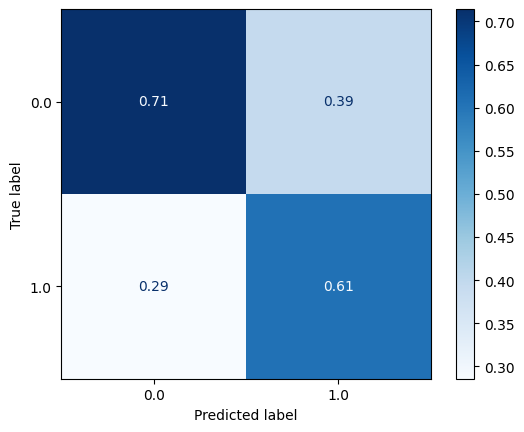

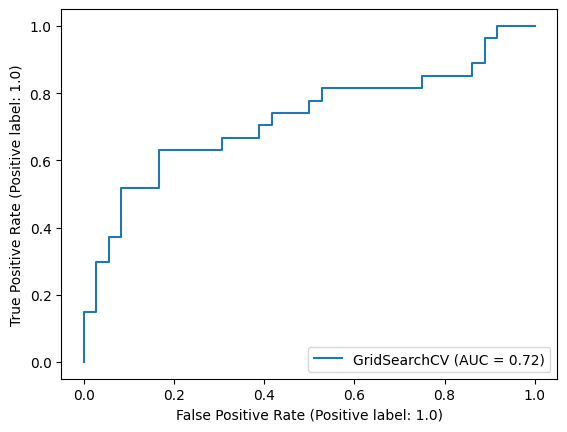

In [56]:
print(f"GridSearchCV best parameters: {grid.best_params_}")
print(f"GridSearchCV best score: {grid.best_score_}")
print(f"GridSearchCV best estimator: {grid.best_estimator_}")

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

cm = ConfusionMatrixDisplay.from_estimator(grid, x_test, y_test, normalize="pred", cmap="Blues")

disp = RocCurveDisplay.from_estimator(grid, x_test, y_test)

Machine learning models can be thought as functions where you plug in input values and get back the output, which can be a vector of label probabilities or a continuous value in regressions. In classification, the function determines a contour in the input feature space. We can visualize how the data points are distributed across this boundary.

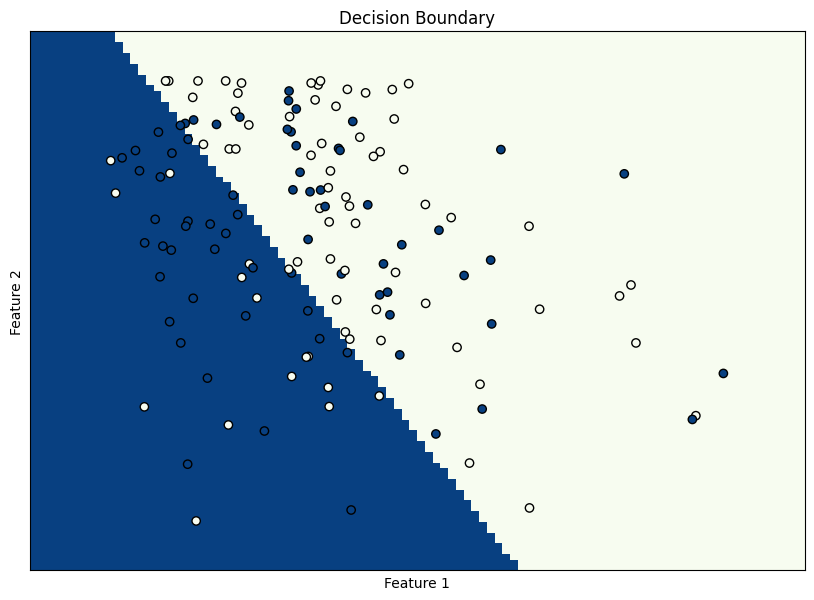

In [57]:
from sklearn.inspection import DecisionBoundaryDisplay

clf = LogisticRegression(random_state=42)

clf.fit(
    x_train[:, 10:12], y_train
)  # only two features from the dataset to plot the decision boundary
_, ax = plt.subplots(figsize=(10, 7))

DecisionBoundaryDisplay.from_estimator(
    clf,
    x_train[:, 10:12],
    response_method="predict",
    cmap="GnBu",
    ax=ax,
    plot_method="pcolormesh",
    shading="auto",
    xlabel="Feature 1",
    ylabel="Feature 2",
    eps=0.1,
)

plt.scatter(x_train[:, 10], x_train[:, 11], c=y_train, edgecolors="k", cmap="GnBu")

plt.title("Decision Boundary")
plt.xticks(())
plt.yticks(())

plt.show()


## Support Vector Machine (SVM)

Starting with the out-of-the-box model without any hyperparameter tunning. Just the default determined by Sklearn team:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81        36
         1.0       0.76      0.70      0.73        27

    accuracy                           0.78        63
   macro avg       0.77      0.77      0.77        63
weighted avg       0.78      0.78      0.78        63



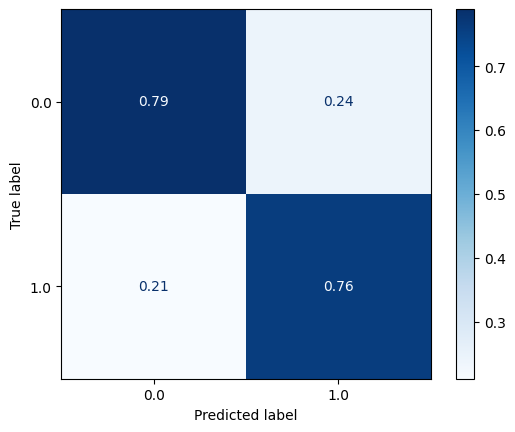

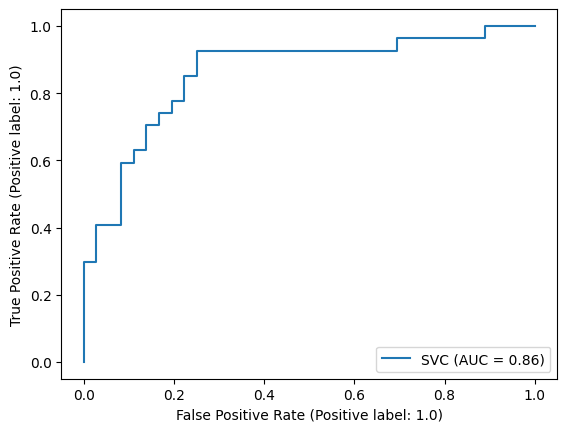

In [58]:
from sklearn.svm import SVC

clf = SVC(random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
cm = ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test, normalize="pred", cmap="Blues")
disp = RocCurveDisplay.from_estimator(clf, x_test, y_test)

Again lets search a grid for the best hyperparameters for the SVC classifier:

In [59]:
# instantiating SVC classifier with fixed random seed for reproducibility
clf = SVC(random_state=42)

# defines parameters' grid
params = {
    "C": np.logspace(-3, 3, 8),
    "gamma": np.logspace(-3, 3, 8),
}
print(params)

grid = GridSearchCV(clf, param_grid=params, cv=5)
grid.fit(x_train, y_train)


{'C': array([1.00000000e-03, 7.19685673e-03, 5.17947468e-02, 3.72759372e-01,
       2.68269580e+00, 1.93069773e+01, 1.38949549e+02, 1.00000000e+03]), 'gamma': array([1.00000000e-03, 7.19685673e-03, 5.17947468e-02, 3.72759372e-01,
       2.68269580e+00, 1.93069773e+01, 1.38949549e+02, 1.00000000e+03])}


GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': array([1.00000000e-03, 7.19685673e-03, 5.17947468e-02, 3.72759372e-01,
       2.68269580e+00, 1.93069773e+01, 1.38949549e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 7.19685673e-03, 5.17947468e-02, 3.72759372e-01,
       2.68269580e+00, 1.93069773e+01, 1.38949549e+02, 1.00000000e+03])})

GridSearchCV best parameters: {'C': 2.6826957952797246, 'gamma': 2.6826957952797246}
GridSearchCV best score: 0.8068965517241379
GridSearchCV best estimator: SVC(C=2.6826957952797246, gamma=2.6826957952797246, random_state=42)
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81        36
         1.0       0.76      0.70      0.73        27

    accuracy                           0.78        63
   macro avg       0.77      0.77      0.77        63
weighted avg       0.78      0.78      0.78        63



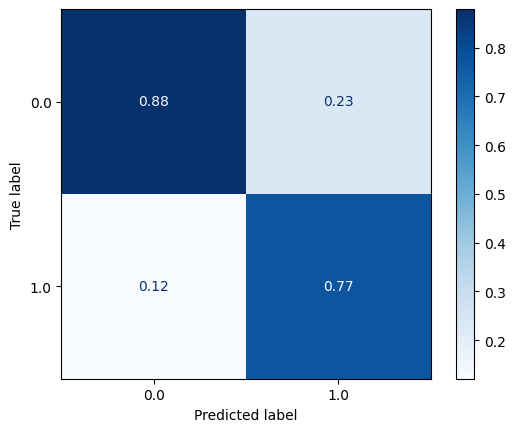

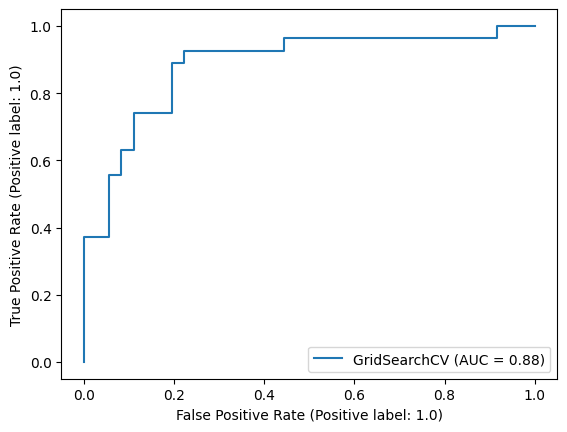

In [60]:
print(f"GridSearchCV best parameters: {grid.best_params_}")
print(f"GridSearchCV best score: {grid.best_score_}")
print(f"GridSearchCV best estimator: {grid.best_estimator_}")

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

cm = ConfusionMatrixDisplay.from_estimator(grid, x_test, y_test, normalize="pred", cmap="Blues")

disp = RocCurveDisplay.from_estimator(grid, x_test, y_test)

Not surprisingly, SVC performs very well both with out-of-the-box and tuned hyperparameters. The plenty of regularization is the one to "blame". It would be interesting to check the decision boundary in this case.

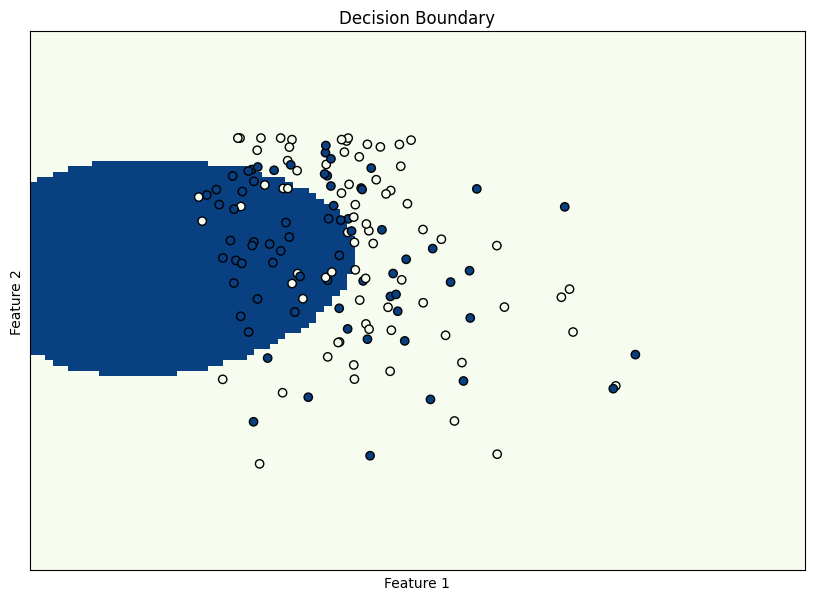

In [61]:
from sklearn.inspection import DecisionBoundaryDisplay

clf = SVC(random_state=42)

clf.fit(
    x_train[:, 10:12], y_train
)  # only two features from the dataset to plot the decision boundary
_, ax = plt.subplots(figsize=(10, 7))

DecisionBoundaryDisplay.from_estimator(
    clf,
    x_train[:, 10:12],
    response_method="predict",
    cmap="GnBu",
    ax=ax,
    plot_method="pcolormesh",
    shading="auto",
    xlabel="Feature 1",
    ylabel="Feature 2",
    eps=0.3,
)

plt.scatter(x_train[:, 10], x_train[:, 11], c=y_train, edgecolors="k", cmap="GnBu")

plt.title("Decision Boundary")
plt.xticks(())
plt.yticks(())

plt.show()


Last things last, making a pipeline that first scales the data and then use the scaled data to train the model.

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([("sc", StandardScaler()),
                     ("model", SVC(random_state=42))])

# defines parameters' grid
params = {
    "model__C": np.logspace(-3, 3, 8),
    "model__gamma": np.logspace(-3, 3, 8),
}
print(params)

grid = GridSearchCV(pipe, param_grid=params, cv=5)
grid.fit(x_train, y_train)


{'model__C': array([1.00000000e-03, 7.19685673e-03, 5.17947468e-02, 3.72759372e-01,
       2.68269580e+00, 1.93069773e+01, 1.38949549e+02, 1.00000000e+03]), 'model__gamma': array([1.00000000e-03, 7.19685673e-03, 5.17947468e-02, 3.72759372e-01,
       2.68269580e+00, 1.93069773e+01, 1.38949549e+02, 1.00000000e+03])}


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('model', SVC(random_state=42))]),
             param_grid={'model__C': array([1.00000000e-03, 7.19685673e-03, 5.17947468e-02, 3.72759372e-01,
       2.68269580e+00, 1.93069773e+01, 1.38949549e+02, 1.00000000e+03]),
                         'model__gamma': array([1.00000000e-03, 7.19685673e-03, 5.17947468e-02, 3.72759372e-01,
       2.68269580e+00, 1.93069773e+01, 1.38949549e+02, 1.00000000e+03])})

GridSearchCV best parameters: {'model__C': 19.306977288832496, 'model__gamma': 0.0517947467923121}
GridSearchCV best score: 0.7724137931034483
GridSearchCV best estimator: Pipeline(steps=[('sc', StandardScaler()),
                ('model',
                 SVC(C=19.306977288832496, gamma=0.0517947467923121,
                     random_state=42))])

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81        36
         1.0       0.76      0.70      0.73        27

    accuracy                           0.78        63
   macro avg       0.77      0.77      0.77        63
weighted avg       0.78      0.78      0.78        63



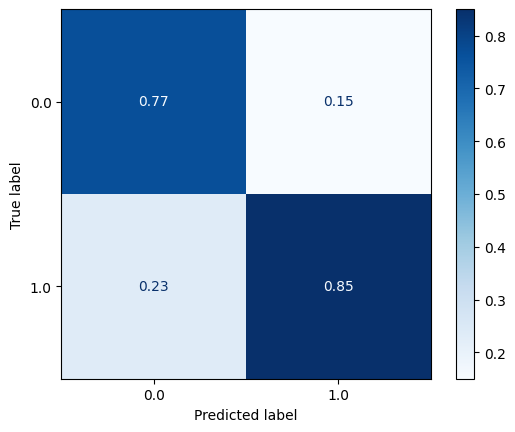

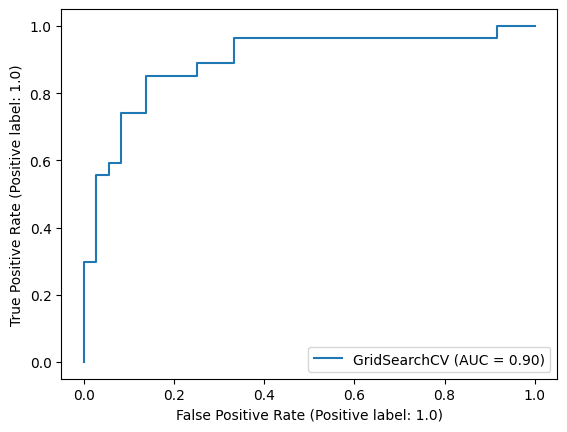

In [63]:
print(f"GridSearchCV best parameters: {grid.best_params_}")
print(f"GridSearchCV best score: {grid.best_score_}")
print(f"GridSearchCV best estimator: {grid.best_estimator_}\n")

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

cm = ConfusionMatrixDisplay.from_estimator(grid, x_test, y_test, normalize="pred", cmap="Blues")

disp = RocCurveDisplay.from_estimator(grid, x_test, y_test)

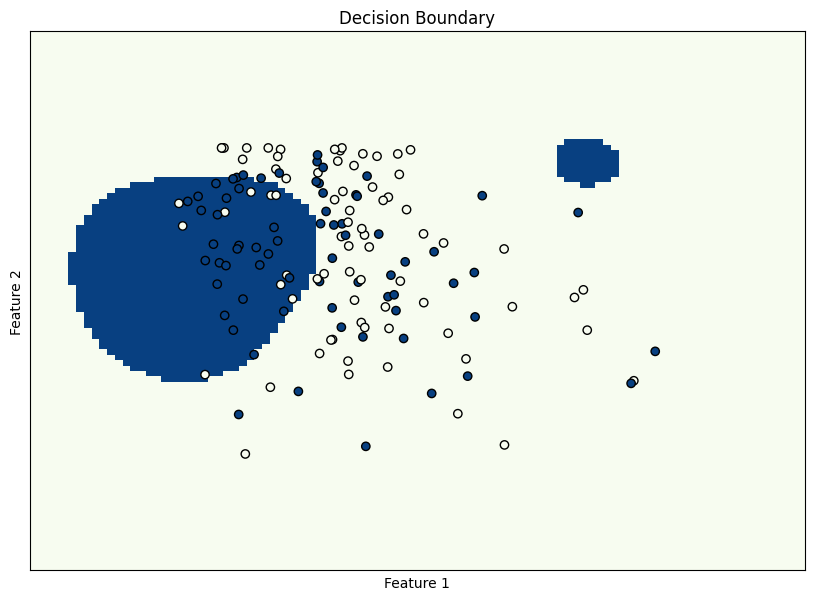

In [64]:
clf = SVC(random_state=42)

sc = StandardScaler()
x_train[:, 10:12] = sc.fit_transform(x_train[:, 10:12])

clf.fit(
    x_train[:, 10:12], y_train
)  # only two features from the dataset to plot the decision boundary
_, ax = plt.subplots(figsize=(10, 7))

DecisionBoundaryDisplay.from_estimator(
    clf,
    x_train[:, 10:12],
    response_method="predict",
    cmap="GnBu",
    ax=ax,
    plot_method="pcolormesh",
    shading="auto",
    xlabel="Feature 1",
    ylabel="Feature 2",
    eps=1.5,
)

plt.scatter(x_train[:, 10], x_train[:, 11], c=y_train, edgecolors="k", cmap="GnBu")

plt.title("Decision Boundary")
plt.xticks(())
plt.yticks(())

plt.show()

## Conclusion
As we can see, build a feedforward neural network in PyTorch is quite simple if one understand basic principles of data preprocessing, neural networks and basic class inheritance in Python. It is also clear that a simple neural network with the right number of neurons and layers can capture the complexity in the data to correctly classify both metal and rock cilinders. However, the classic machine learning algorithms such as Logistic Regression and Support Vector Machine classifier can do a pretty good job classifying the samples. In fact, the neural network has a bit more capacity in classifying metal cylinder (label 0) than logit and SVC. It is also clear that regularization can improve significantly the performance of machine learning models when dealing with previously unseen data because models trained under such constrains to alow generalization power.